In [ ]:
!git clone https://github.com/herm23/Project-NNDL.git

In [ ]:
%cd Project-NNDL/

Link per il datset di CompCar (trovato su sito ufficiale): https://drive.google.com/drive/folders/18EunmjOJsbE5Lh9zA0cZ4wKV6Um46dkg


In [ ]:
!pip install -U -q PyDrive

Import necessari

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

Scarico i dati direttamente dal drive pubblico

In [ ]:
#Autenticazione
auth.authenticate_user()

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Estrazione dei dati dalla cartella
# ID della cartella pubblica
folder_id = '18EunmjOJsbE5Lh9zA0cZ4wKV6Um46dkg'

# Cartella locale per salvare i dati
save_path = '/content/Project-NNDL/compcar_dataset'
os.makedirs(save_path, exist_ok=True)

# Lista file nella cartella Drive
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

# Scarica tutti i file
for file in file_list:
    print(f"Scaricando {file['title']}")
    file.GetContentFile(os.path.join(save_path, file['title']))



In [ ]:
!apt-get install -y p7zip-full


In [ ]:
%cd /content/Project-NNDL/compcar_dataset

password per unzippare: d89551fd190e38

In [ ]:
!7z x data.zip -o./compcar_dataset/unzipped

# Creo i Dataest

In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import scipy.io as sio

#Wrapper del dataset per fare la funzione di classificazione delle marche, operazione di base
class CarMakeDataset(Dataset):
  def __init__(self, img_root, mat_path, transform=None):
    """
    img_root: root of compcar dataset images
    mat_path: root of compcar matrix for the conversion between numbers and make name
    transform: some possible transformations done with pythorch
    """
    #Cose da fare domani:
    #1) leggi il file 1 il file .mat e cerca di capire come è fatto.
    #2) fai in modo di avere come sample le immagini da una parte e il corrispettivo modello dall'altra, magari usa un oggetto per farlo
    #3) Verifica che il dataset sia caricato correttamente con qualche prova
    #4) Continua il lab 4 leggendo come implementare le resnet e poi cerca di costruire la tua prima rete. La cosa top sarebbe fare già qualche prova per giovedi/venerdi !!!


KeyboardInterrupt: 

Test visualizzazione immagini

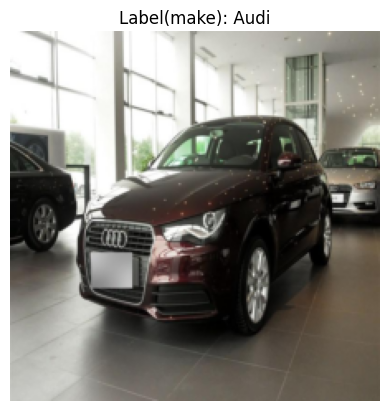

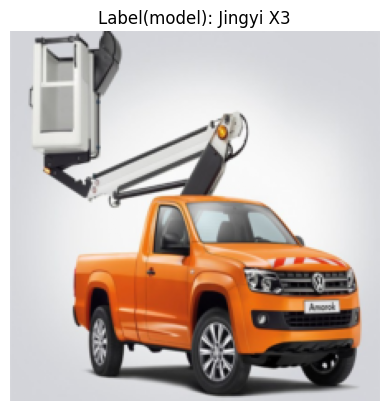

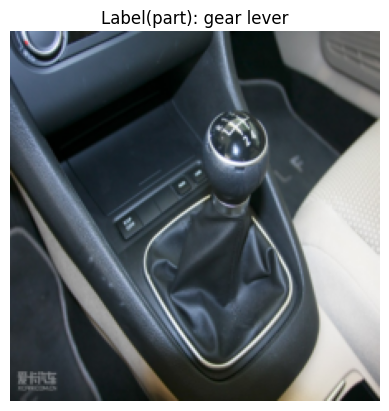

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np

img, label = train_dataset_make[0]
plt.imshow(img.permute(1, 2, 0).numpy())
plt.title(f"Label(make): {train_dataset_make.dataset.idx_to_class[label]}")
plt.axis('off')
plt.show()

# Rete Inception

In [ ]:
from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter
import torch
import os
import pandas as pd
import h5py
import random
import numpy as np

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
transforms = Compose([
    ToTensor(), #this converts numpy or Pil image to torch tensor and normalizes it in 0, 1
    RandomAffine((0.05, 0.05)),
    RandomHorizontalFlip(),
    RandomVerticalFlip()
])